In [1]:
import sys
sys.path.append("..")

In [ ]:
import os

import lightning as L
import matplotlib.pyplot as plt
import torch

from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

from config.config import Config
from config.json_parser import parse_json
from model import Model
from utils.load_dataset import load_dataset
from utils.load_network import load_network

L.seed_everything(42)

Seed set to 42


42

In [3]:
CONFIG_PATH = "../config.example.json"

In [4]:
config: Config = parse_json(CONFIG_PATH)
config.batch_size = 1

if torch.cuda.is_available():
    print("[INFO] CUDA is available! Training on GPU...")
else:
    print("[INFO] CUDA is not available. Training on CPU...")

dataset = load_dataset(config)
test_loader = dataset.generate_test_loader()
data_iter = iter(test_loader)

network = load_network(config, dataset.num_classes)

weights_path = f"{os.path.join(os.getcwd(), "..")}/{config.weights_dir}/{config.weights_path}.ckpt"
model = Model.load_from_checkpoint(
    weights_path, network=network, config=config, num_classes=dataset.num_classes
)

[INFO] CUDA is available! Training on GPU...


In [5]:
import numpy as np
def reverse_transform(input):
    inp = input[0]
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])

    
    inp = inp.numpy().transpose((1, 2, 0))
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)

    return inp

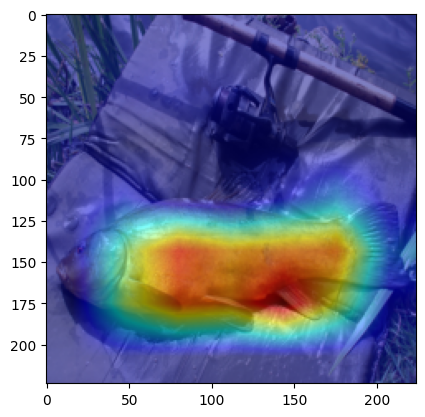

In [6]:
target_layers = [model.network.model.features[-1][-1]]

inputs, targets = next(data_iter)

targets = [ClassifierOutputTarget(targets)]

with GradCAM(model=model.network, target_layers=target_layers) as cam:
  grayscale_cam = cam(input_tensor=inputs, targets=targets)
  grayscale_cam = grayscale_cam[0, :]
  visualization = show_cam_on_image(reverse_transform(inputs), grayscale_cam, use_rgb=True)
  model_outputs = cam.outputs

plt.imshow(visualization)